# 1. Introduction

Accurately predicting the stock markets is a complex task as there are millions of events and pre-conditions for a particilar stock to move in a particular direction. So we need to be able to capture as many of these pre-conditions as possible. We also need make several important assumptions: 1) markets are not 100% random, 2) history repeats, 3) markets follow people's rational behavior, and 4) the markets are 'perfect'. And, please, do read the Disclaimer at the bottom.

We will try to predict the price movements of Goldman Sachs (NYSE: GS). For the purpose, we will use daily closing price from January 1st, 2010 to December 31st, 2018 (seven years for training purposes and two years for validation purposes). We will use the terms 'Goldman Sachs' and 'GS' interchangeably.



# 2. The Data
We need to understand what affects whether GS's stock price will move up or down. It is what people as a whole think. Hence, we need to incorporate as much information (depicting the stock from different aspects and angles) as possible. (We will use daily data - 1,585 days to train the various algorithms (70% of the data we have) and predict the next 680 days (test data). Then we will compare the predicted results with a test (hold-out) data. Each type of data (we will refer to it as feature) is explained in greater detail in later sections, but, as a high level overview, the features we will use are:

1. Correlated assets - these are other assets (any type, not necessarily stocks, such as commodities, FX, indices, or even fixed income securities). A big company, such as Goldman Sachs, obviously doesn't 'live' in an isolated world - it depends on, and interacts with, many external factors, including its competitors, clients, the global economy, the geo-political situation, fiscal and monetary policies, access to capital, etc. The details are listed later.
2. Technical indicators - a lot of investors follow technical indicators. We will include the most popular indicators as independent features. Among them - 7 and 21 days moving average, exponential moving average, momentum, Bollinger bands, MACD.
3. Fundamental analysis - A very important feature indicating whether a stock might move up or down. There are two features that can be used in fundamental analysis: 1) Analysing the company performance using 10-K and 10-Q reports, analysing ROE and P/E, etc (we will not use this), and 2) News - potentially news can indicate upcoming events that can potentially move the stock in certain direction. We will read all daily news for Goldman Sachs and extract whether the total sentiment about Goldman Sachs on that day is positive, neutral, or negative (as a score from 0 to 1). As many investors closely read the news and make investment decisions based (partially of course) on news, there is a somewhat high chance that if, say, the news for Goldman Sachs today are extremely positive the stock will surge tomorrow. One crucial point, we will perform feature importance (meaning how indicative it is for the movement of GS) on absolutely every feature (including this one) later on and decide whether we will use it. More on that later.

  For the purpose of creating accurate sentiment prediction we will use Neural Language Processing (NLP). We will use BERT - Google's recently announced NLP approach for transfer learning for sentiment classification stock news sentiment extraction.


4. Fourier transforms - Along with the daily closing price, we will create Fourier transforms in order to generalize several long- and short-term trends. Using these transforms we will eliminate a lot of noise (random walks) and create approximations of the real stock movement. Having trend approximations can help the LSTM network pick its prediction trends more accurately.
5. Autoregressive Integrated Moving Average (ARIMA) - This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). Let's add it and see if it comes off as an important predictive feature.
6. Stacked autoencoders - most of the aforementioned features (fundamental analysis, technical analysis, etc) were found by people after decades of research. But maybe we have missed something. Maybe there are hidden correlations that people cannot comprehend due to the enormous amount of data points, events, assets, charts, etc. With stacked autoencoders (type of neural networks) we can use the power of computers and probably find new types of features that affect stock movements. Even though we will not be able to understand these features in human language, we will use them in the GAN.
7. Deep Unsupervised learning for anomaly detection in options pricing. We will use one more feature - for every day we will add the price for 90-days call option on Goldman Sachs stock. Options pricing itself combines a lot of data. The price for options contract depends on the future value of the stock (analysts try to also predict the price in order to come up with the most accurate price for the call option). Using deep unsupervised learning (Self-organized Maps) we will try to spot anomalies in every day's pricing. Anomaly (such as a drastic change in pricing) might indicate an event that might be useful for the LSTM to learn the overall stock pattern.

Next, having so many features, we need to perform a couple of important steps:

1. Perform statistical checks for the 'quality' of the data. If the data we create is flawed, then no matter how sophisticated our algorithms are, the results will not be positive. The checks include making sure the data does not suffer from heteroskedasticity, multicollinearity, or serial correlation.
2. Create feature importance. If a feature (e.g. another stock or a technical indicator) has no explanatory power to the stock we want to predict, then there is no need for us to use it in the training of the neural nets. We will using XGBoost (eXtreme Gradient Boosting), a type of boosted tree regression algorithms.

As a final step of our data preparation, we will also create Eigen portfolios using Principal Component Analysis (PCA) in order to reduce the dimensionality of the features created from the autoencoders.

In [1]:
from utils import *

import pandas as pd
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

Note: The purpose of this section (3. The Data) is to show the data preprocessing and to give rationale for using different sources of data, hence I will only use a subset of the full data (that is used for training).

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
from alpha_vantage.timeseries import TimeSeries
key = 'BJUEJ3R9ZM8ER5KY'
ts = TimeSeries(key=key, output_format='pandas')

In [11]:
for i in np.arange(10):
    try:
        data, meta_data = ts.get_daily(symbol='GS', outputsize='full')
        break
    except:
        print('Attempt # {} failed'.format(str(i)))

Attempt # 0 failed
Attempt # 1 failed
Attempt # 2 failed
Attempt # 3 failed
Attempt # 4 failed
Attempt # 5 failed
Attempt # 6 failed
Attempt # 7 failed


In [17]:
dataset_base = pd.DataFrame({'Date':data.index,'GS':data['4. close']})
dataset_base['Date'] = [parser(x) for x in dataset_base['Date']]
dataset_base.head()

,Date,GS
date,,
1999-05-04,1999-05-04,70.38
1999-05-05,1999-05-05,69.13
1999-05-06,1999-05-06,67.94
1999-05-07,1999-05-07,74.13
1999-05-10,1999-05-10,70.69


In [18]:
print('There are {} number of days in the dataset.'.format(dataset_base.shape[0]))

There are 5088 number of days in the dataset.


Let's visualize the stock for the last nine years. The dashed vertical line represents the separation between training and test data.

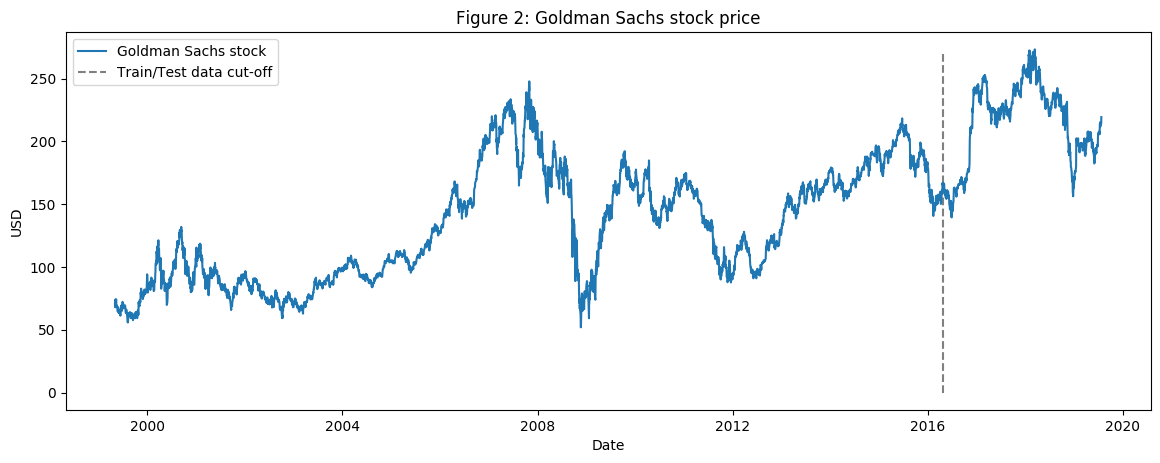

In [19]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_base['Date'], dataset_base['GS'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [20]:
num_training_days = int(dataset_base.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_base.shape[0]-num_training_days))


Number of training days: 3561. Number of test days: 1527.


# 3.1. Correlated assets
As explained earlier we will use other assets as features, not only GS.

So what other assets would affect GS's stock movements? Good understanding of the company, its lines of businesses, competitive landscape, dependencies, suppliers and client type, etc is very important for picking the right set of correlated assets:

* First are the companies similar to GS. We will add JPMorgan Chase and Morgan Stanley, among others, to the dataset.
* As an investment bank, Goldman Sachs depends on the global economy. Bad or volatile economy means no M&As or IPOs, and possibly limited proprietary trading earnings. That is why we will include global economy indices. Also, we will include LIBOR (USD and GBP denominated) rate, as possibly shocks in the economy might be accounted for by analysts to set these rates, and other FI securities.
* Daily volatility index (VIX) - for the reason described in the previous point.
* Composite indices - such as NASDAQ and NYSE (from USA), FTSE100 (UK), Nikkei225 (Japan), Hang Seng and BSE Sensex (APAC) indices.
* Currencies - global trade is many times reflected into how currencies move, ergo we'll use a basket of currencies (such as USDJPY, GBPUSD, etc) as features.

**Overall, we have 72 other assets in the dataset - daily price for every asset.**

In [21]:
tickers_corr = {'jpm':'JPM', 'ms':'MS', 'vix':'VIX', 'nasdaq':'NASDAQ:^IXIC', 'nya':'NYA',
               'usdjpy': 'USDJPY', 'gbpusd':'GBPUSD', 'usdeur':'USDEUR', 'nikkei':'^N225', 
                'sp500':'^GSPC', 'hangseng':'HSI'}

In [50]:
o = []
for i in tickers_corr.keys():
    for j in np.arange(30):
        try:
            temp, md = ts.get_daily(symbol=[tickers_corr[i]], outputsize='full')
            temp = temp[['4. close']]
            temp.columns = ['close']
            temp['type'] = i
            o.append(temp)
            break
        except:
            time.sleep(5)

o = pd.concat(o)
o['type'].value_counts()

gbpusd      5447
usdjpy      5447
ms          5423
jpm         5423
nikkei      4925
sp500       4919
nasdaq      4919
vix         4919
nya         4888
hangseng    4887
usdeur      4083
Name: type, dtype: int64

In [51]:
bad = list(set(o['type'].unique())-set(tickers_corr.keys()))
print(len(bad))

0


In [52]:
o.head()

,close,type
date,,
1998-01-02,110.62,jpm
1998-01-05,112.44,jpm
1998-01-06,107.19,jpm
1998-01-07,108.38,jpm
1998-01-08,104.19,jpm


In [56]:
corr_assets = o.pivot_table(index=o.index, columns='type', values='close')
corr_assets.head()

type,gbpusd,hangseng,jpm,ms,nasdaq,nikkei,nya,sp500,usdeur,usdjpy,vix
date,,,,,,,,,,,
1998-01-02,1.6405,NaN,110.62,58.75,NaN,NaN,NaN,NaN,NaN,132.32,NaN
1998-01-05,1.6380,NaN,112.44,60.88,NaN,NaN,NaN,NaN,NaN,133.88,NaN
1998-01-06,1.6327,NaN,107.19,60.00,NaN,NaN,NaN,NaN,NaN,133.53,NaN
1998-01-07,1.6242,NaN,108.38,58.50,NaN,NaN,NaN,NaN,NaN,132.07,NaN
1998-01-08,1.6155,NaN,104.19,58.94,NaN,NaN,NaN,NaN,NaN,132.55,NaN


# 3.2. Technical indicators
We already covered what are technical indicators and why we use them so let's jump straight to the code. We will create technical indicators only for GS.

In [57]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7, min_periods=1).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21, min_periods=1).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['price'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['price'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['20sd'] = dataset['price'].rolling(20, min_periods=0).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

In [58]:
dataset_base['price'] = dataset_base['GS']
technical_indicators = get_technical_indicators(dataset_base[['price']])
technical_indicators.head()

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
date,,,,,,,,,,,,
1999-05-04,70.38,70.380,70.380,70.380000,70.380000,0.000000,NaN,NaN,NaN,70.380000,69.38,4.239599
1999-05-05,69.13,69.755,69.755,70.287407,70.187692,-0.099715,0.883883,71.522767,67.987233,69.442500,68.13,4.221418
1999-05-06,67.94,69.150,69.150,70.113525,69.841893,-0.271632,1.220123,71.590246,66.709754,68.402308,66.94,4.203797
1999-05-07,74.13,70.395,70.395,70.411042,70.501602,0.090560,2.681896,75.758792,65.031208,72.268500,73.13,4.292239
1999-05-10,70.69,70.454,70.454,70.431706,70.530586,0.098881,2.326334,75.106668,65.801332,71.211818,69.69,4.244057


So we have the technical indicators (including MACD, Bollinger bands, etc) for every trading day. We have in total 12 technical indicators.

Let's visualize the last 400 days of these indicators.

In [59]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, 0, last_days, colors='g', linestyles='--')
    plt.hlines(-15, 0, last_days, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

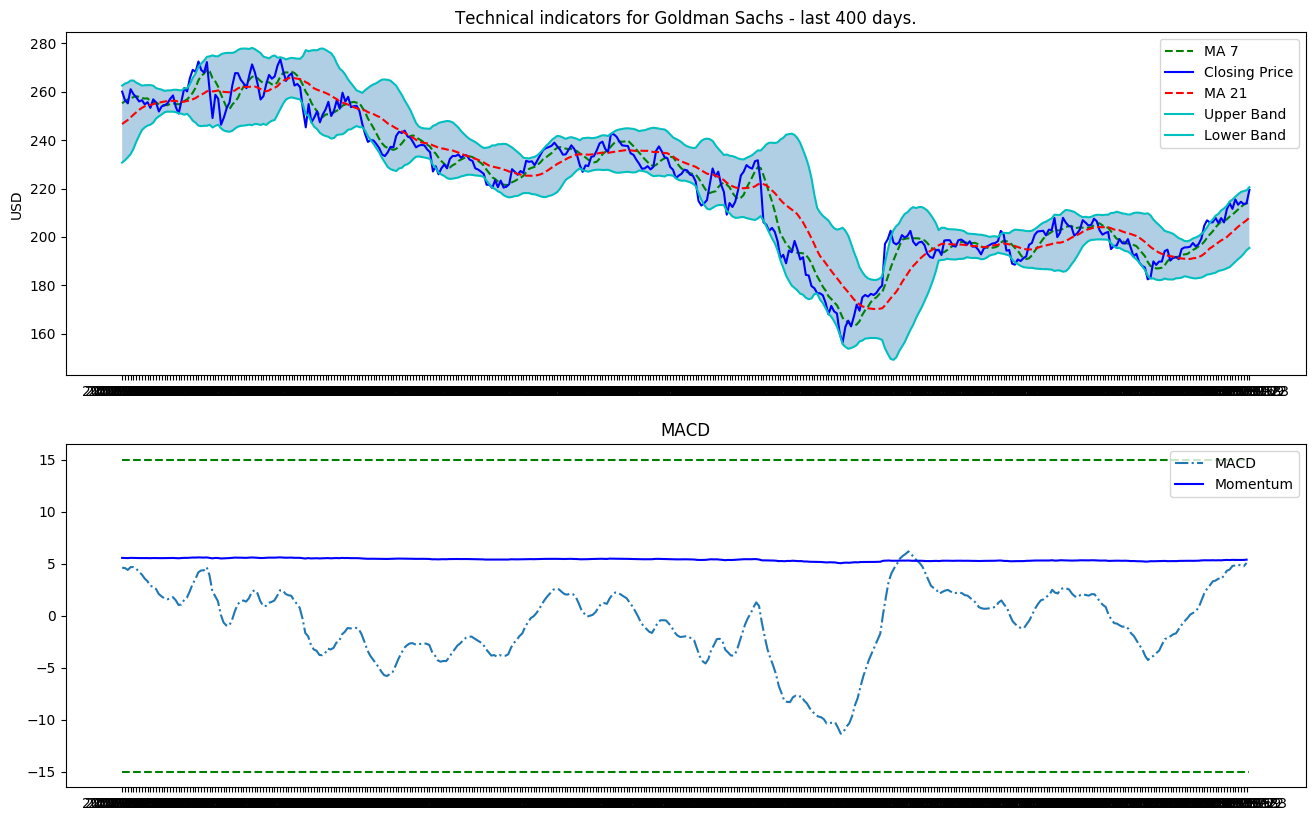

In [60]:
plot_technical_indicators(technical_indicators, 400)

## 3.3. Fundamental analysis
For fundamental analysis we will perform sentiment analysis on all daily news about GS. Using sigmoid at the end, result will be between 0 and 1. The closer the score is to 0 - the more negative the news is (closer to 1 indicates positive sentiment). For each day, we will create the average daily score (as a number between 0 and 1) and add it as a feature.

### 3.3.1. Bidirectional Embedding Representations from Transformers - BERT
For the purpose of classifying news as positive or negative (or neutral) we will use BERT, which is a pre-trained language representation.

Pretrained BERT models are already available in MXNet/Gluon. We just need to instantiated them and add two (arbitrary number) Dense layers, going to softmax - the score is from 0 to 1.

In [ ]:
# just import bert
import bert

In [89]:
import json, requests

In [90]:
q = 'https://stocknewsapi.com/api/v1?tickers=GS&items=50&token=vteixkw9an9ggtxuv54gqqrptqmx5fxoxtct73vs'
r = requests.get(q)

In [94]:
r.content

b'{\n    "data": [\n        {\n            "title": "3 Top Bank Stocks to Buy Right Now",\n            "news_url": "https://www.fool.com/investing/2019/07/24/3-top-bank-stocks-to-buy-right-now.aspx",\n            "image_url": "https://cdn.snapi.dev/images/v1/a/e/urlhttps3a2f2fgfoolcdncom2feditorial2fimages2f5320412fbank-sign-on-buildingjpgw700opresize.jpg",\n            "text": "Now that we\'ve seen second-quarter earnings from the big banks, our contributors think these three are worth a closer look.",\n            "sentiment": "Positive",\n            "type": "Article",\n            "source_name": "The Motley Fool",\n            "date": "Wed, 24 Jul 2019 09:35:00 -0400",\n            "tickers": [\n                "BAC",\n                "GS",\n                "WFC"\n            ],\n            "topics": []\n        },\n        {\n            "title": "Why Private Detectives Are Eyeing a Goldman Bond Deal Gone Bust",\n            "news_url": "https://www.youtube.com/watch?v=M-RkOpm3hf

In [96]:
j = r.json()
j

{'data': [{'title': '3 Top Bank Stocks to Buy Right Now',
   'news_url': 'https://www.fool.com/investing/2019/07/24/3-top-bank-stocks-to-buy-right-now.aspx',
   'image_url': 'https://cdn.snapi.dev/images/v1/a/e/urlhttps3a2f2fgfoolcdncom2feditorial2fimages2f5320412fbank-sign-on-buildingjpgw700opresize.jpg',
   'text': "Now that we've seen second-quarter earnings from the big banks, our contributors think these three are worth a closer look.",
   'sentiment': 'Positive',
   'type': 'Article',
   'source_name': 'The Motley Fool',
   'date': 'Wed, 24 Jul 2019 09:35:00 -0400',
   'tickers': ['BAC', 'GS', 'WFC'],
   'topics': []},
  {'title': 'Why Private Detectives Are Eyeing a Goldman Bond Deal Gone Bust',
   'news_url': 'https://www.youtube.com/watch?v=M-RkOpm3hfI',
   'image_url': 'https://cdn.snapi.dev/images/v1/x/s/why-private-detectives-are-eyeing-a-goldman-bond-deal-gone-bust.jpg',
   'text': 'A Goldman Sachs bond deal went bust, and a group of creditors have now resorted to hiring p

In [98]:
o = []
for i in j['data']:
    oo = {'title':i['title'],'text':i['text'], 'date':i['date'], 'sentiment':i['sentiment']}
    o.append(oo)
    
o = pd.DataFrame(o)
o.to_csv('train_data_50_rows.tsv', sep='\t', index=False)
o

,date,sentiment,text,title
0,"Wed, 24 Jul 2019 09:35:00 -0400",Positive,Now that we've seen second-quarter earnings fr...,3 Top Bank Stocks to Buy Right Now
1,"Mon, 22 Jul 2019 18:07:27 -0400",Neutral,"A Goldman Sachs bond deal went bust, and a gro...",Why Private Detectives Are Eyeing a Goldman Bo...
2,"Mon, 22 Jul 2019 14:31:07 -0400",Positive,"The ""Halftime Report"" traders debate Goldman S...",Goldman upgrades these chip stocks
3,"Fri, 19 Jul 2019 13:15:02 -0400",Negative,"EVP, Global Head of HCM of Goldman Sachs Group...","Goldman Sachs Group Inc (GS) EVP, Global Head ..."
4,"Fri, 19 Jul 2019 10:10:21 -0400",Positive,Goldman Sachs BDC (GSBD) has an impressive ear...,Can Goldman Sachs BDC (GSBD) Keep the Earnings...
5,"Thu, 18 Jul 2019 16:57:47 -0400",Negative,Booming stock markets around the globe helped ...,Goldman Sachs' equities-backed earnings result...
6,"Thu, 18 Jul 2019 14:05:03 -0400",Positive,"The ""Halftime Report"" traders give their top s...","Final Trades: Abbott Labs, Goldman Sachs, Disn..."
7,"Thu, 18 Jul 2019 10:49:37 -0400",Positive,Don't fret! Value stocks can be had in today's...,3 Great Value Stocks to Buy This July
8,"Thu, 18 Jul 2019 07:08:11 -0400",Negative,Booming stock markets around the globe helped ...,Goldman Sachs' equities-backed earnings result...
9,"Wed, 17 Jul 2019 23:59:49 -0400",Positive,GS released Q2 results July 16th and has recen...,"The Goldman Sachs Group, Inc. - Friend Of The ..."


Going into the details of BERT and the NLP part is not in the scope of this notebook, but you have interest, do let me know - I will create a new repo only for BERT as it definitely is quite promissing when it comes to language processing tasks.

## 3.4. Fourier transforms for trend analysis
Fourier transforms take a function and create a series of sine waves (with different amplitudes and frames). When combined, these sine waves approximate the original function. Mathematically speaking, the transforms look like this:

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$

We will use Fourier transforms to extract global and local trends in the GS stock, and to also denoise it a little. So let's see how it works.

In [ ]:
data_FT = dataset_ex_df[['Date', 'GS']]

In [ ]:
close_fft = np.fft.fft(np.asarray(data_FT['GS'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [ ]:
plt.figure(figsize=(14, 7))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['GS'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

As you see in Figure 3 the more components from the Fourier transform we use the closer the approximation function is to the real stock price (the 100 components transform is almost identical to the original function - the red and the purple lines almost overlap). We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

Another technique used to denoise data is call wavelets. Wavelets and Fourier transform gave similar results so we will only use Fourier transforms.

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## 3.5. ARIMA as a feature
ARIMA is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['GS']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real', linestyle='--')
plt.plot(predictions, color='red', label='Predicted', linestyle='--')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because, as we mentioned before, we want to capture as many features and patterns about Goldman Sachs as possible. We go test MSE (mean squared error) of 10.151, which by itself is not a bad result (considering we do have a lot of test data), but still we will only use it as a feature in the LSTM.

# 3.6. Statistical checks
Ensuring that the data has good quality is very important for out models. In order to make sure our data is suitable we will perform a couple of simple checks in order to ensure that the results we achieve and observe are indeed real, rather than compromised due to the fact that the underlying data distribution suffers from fundamental errors.

## 3.6.1. Heteroskedasticity, multicollinearity, serial correlation
Conditional Heteroskedasticity occurs when the error terms (the difference between a predicted value by a regression and the real value) are dependent on the data - for example, the error terms grow when the data point (along the x-axis) grow.
Multicollinearity is when error terms (also called residuals) depend on each other.
Serial correlation is when one data (feature) is a formula (or completely depemnds) of another feature.
We will not go into the code here as it is straightforward and our focus is more on the deep learning parts, but the data is qualitative.

# 3.7. Feature Engineering

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))